In [ ]:
# default_exp tabular.learner

# tabular.learner

> API details.

In [ ]:
#export
from fastai.torch_basics import *
from fastai.data.all import *
from fastai.tabular.data import *
from fastai.tabular.core import *
from fastai.tabular.model import *
from fastai.basics import *
from fastrenewables.tabular.core import *
from fastrenewables.tabular.data import *
from fastrenewables.tabular.model import *
from fastrenewables.losses import VILoss

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
class RenewableLearner(Learner):
    "`Learner` for renewable data"
    def predict(self, ds_idx=1, test_dl=None, filter=True):
        device = next(self.model.parameters()).device
        preds, targets = None, None
        if test_dl is not None:
            to = test_dl.train_ds
        elif ds_idx == 0:
            to = self.dls.train_ds
        elif ds_idx == 1:
            to = self.dls.valid_ds
            
        # to increase speed we direclty predict on all tensors    
        if isinstance(to, (TabularPandas, TabularRenewables, TabDataLoader)):
            if getattr(to, 'regression_setup', False):
                ys_type = np.float32
            else:
                ys_type = np.long
            
            cats = tensor(to.cats.values.astype(np.long))
            xs = tensor(to.conts.values.astype(np.float32))
            targets = tensor(to.y.values.astype(ys_type))
        
            with torch.no_grad():
                preds = self.model(cats.to(device), xs.to(device))

            preds, targets = to_np(preds).reshape(-1), to_np(targets).reshape(-1)
            if filter:
                preds[preds < 0] = 0
                preds[preds > 1.1] = 1.1
        else:
            raise NotImplementedError("Unknown type")
            
        return preds, targets

In [ ]:
np.long

int

In [ ]:
show_doc(RenewableLearner, title_level=3)

<h3 id="RenewableLearner" class="doc_header"><code>class</code> <code>RenewableLearner</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>RenewableLearner</code>(**`dls`**, **`model`**, **`loss_func`**=*`None`*, **`opt_func`**=*`Adam`*, **`lr`**=*`0.001`*, **`splitter`**=*`trainable_params`*, **`cbs`**=*`None`*, **`metrics`**=*`None`*, **`path`**=*`None`*, **`model_dir`**=*`'models'`*, **`wd`**=*`None`*, **`wd_bn_bias`**=*`False`*, **`train_bn`**=*`True`*, **`moms`**=*`(0.95, 0.85, 0.95)`*) :: `Learner`

`Learner` for renewable data

In [ ]:
def get_dls(cat_names = ['TaskID', 'Month', 'Day', 'Hour']):
    pd.options.mode.chained_assignment=None
    cont_names = ['T_HAG_2_M', 'RELHUM_HAG_2_M', 'PS_SFC_0_M', 'ASWDIFDS_SFC_0_M',
           'ASWDIRS_SFC_0_M', 'WindSpeed58m']
    dls = RenewableDataLoaders.from_files(glob.glob("../data/*.h5"), y_names="PowerGeneration", 
                                          pre_procs=[FilterYear(year=2020), 
                                                     AddSeasonalFeatures(as_cont=False)], 
                                          cat_names=cat_names, cont_names=cont_names)
    return dls

In [ ]:
#export
@delegates(Learner.__init__)
def renewable_learner(dls, layers=None, emb_szs=None, config=None, n_out=None, y_range=None, embedding_type=EmbeddingType.Normal, **kwargs):
    "Get a `Learner` using `dls`, with `metrics`, including a `TabularModel` created using the remaining params."
    if config is None: config = tabular_config()
    
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    
    if layers is None: layers = [len(dls.cont_names), 200, 100, n_out]
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
        
    embed_p = kwargs["embed_p"].pop() if "embed_p" in kwargs.keys() else 0.1
    
    emb_module = None
    if len(dls.train_ds.cat_names) > 0:
        emb_szs = get_emb_sz(dls.train_ds, {} if emb_szs is None else emb_szs)
        emb_module = EmbeddingModule(None, embedding_dropout=embed_p, embedding_dimensions=emb_szs)
        
    model = MultiLayerPerceptron(layers, embedding_module=emb_module, **config)
    
    if embedding_type==EmbeddingType.Bayes and "loss_func" not in kwargs.keys():
        base_loss = getattr(dls.train_ds, 'loss_func', None)
        assert base_loss is not None, "Could not infer loss function from the data, please pass a loss function."
        loss_func=VILoss(model=model, base_loss=base_loss, kl_weight=0.1)
        kwargs["loss_func"] = loss_func
    
    return RenewableLearner(dls, model, **kwargs)

In [ ]:
# hide
dls = get_dls(cat_names=[])
# get_files adds task ID, but we want to check if no embedding module is created when no categoricals are available
dls.train_ds.cat_names = []
dls.valid_ds.cat_names = []
learn = renewable_learner(dls, metrics=rmse)
test_eq(None, learn.model.embedding_module)

In [ ]:
dls = get_dls()
learn = renewable_learner(dls, metrics=rmse)
learn.model

MultiLayerPerceptron(
  (embedding_module): EmbeddingModule(
    (embeddings): ModuleList(
      (0): Embedding(4, 3)
      (1): Embedding(13, 7)
      (2): Embedding(32, 11)
      (3): Embedding(25, 10)
    )
    (emb_drop): Dropout(p=0.1, inplace=False)
  )
  (final_activation): Identity()
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(37, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=37, out_features=200, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=200, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)

In [ ]:
dls.show_batch()

,TaskID,Month,Day,Hour,T_HAG_2_M,RELHUM_HAG_2_M,PS_SFC_0_M,ASWDIFDS_SFC_0_M,ASWDIRS_SFC_0_M,WindSpeed58m,PowerGeneration
0,1,3,7,11,283.236,71.458,96165.065983,61.109000,48.930001,14.251200,0.952
1,0,3,24,19,279.771,58.434,101355.694948,72.117000,39.750999,5.321872,0.001
2,2,6,19,22,290.143,69.654,93124.964996,95.048999,237.924003,2.024396,0.008
3,1,7,24,0,293.759,71.024,98371.031006,58.641000,255.804992,2.480045,0.000
4,1,7,17,2,286.516,90.616,98062.999999,117.441001,55.842000,0.205645,0.001
5,1,9,20,7,280.669,68.200,99331.937944,45.388000,107.953000,0.600171,0.000
6,1,3,15,4,276.611,89.750,97003.699013,35.493999,2.179998,8.947007,0.458
7,1,12,12,19,274.293,85.290,96328.219025,15.295001,2.641001,7.085374,0.010
8,0,12,30,15,275.202,72.932,101774.620983,25.209001,22.711002,2.177185,0.000
9,1,10,23,20,283.886,94.397,97739.745993,51.430000,43.796999,2.807249,0.001


In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,_rmse,time
0,0.015376,0.013584,0.116548,00:02


In [ ]:
n_conts=len(dls.cont_names)
hidden_layers = [n_conts] + get_structure(n_conts*20,90,10)
learn = renewable_learner(dls, metrics=rmse, layers=hidden_layers, embedding_type=EmbeddingType.Bayes)

In [ ]:
learn.summary()

MultiLayerPerceptron (Input shape: 64 x torch.Size([64, 6]))
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 3              
Embedding                                 12         True      
____________________________________________________________________________
                     64 x 7              
Embedding                                 91         True      
____________________________________________________________________________
                     64 x 11             
Embedding                                 352        True      
____________________________________________________________________________
                     64 x 10             
Embedding                                 250        True      
Dropout                                                        
Identity                                                       
BatchNorm1d                               12         True      
BatchNorm1d                 

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,_rmse,time
0,0.015357,0.012879,0.113487,00:03


In [ ]:
preds,target = learn.predict(ds_idx=1)

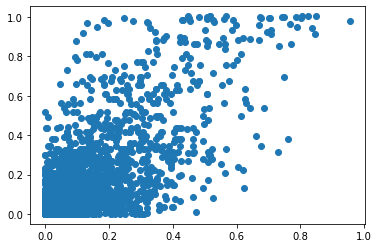

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(preds,target)

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_losses.ipynb.
Converted 01_tabular.core.ipynb.
Converted 02_tabular.data.ipynb.
Converted 03_tabular.model.ipynb.
Converted 04_tabular.learner.ipynb.
Converted index.ipynb.
